In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array

In [81]:
import glob
import random

11.1 Prepare Image Data

In [83]:
#List all filename in art image path
image_size = (32,32,3)
filenames = glob.glob("./Art_Image_dataset/*/*/*.jpg")
train_dataset = []   # read image from dataset and resize to train_dataset.shape = ima_size using interpolation = "bilinear"
original_dataset = []

# rescale train_dataset values [0,255] -> [-1,1]

In [115]:
print(filenames.__len__())

3075


(3075, 32, 32, 3)


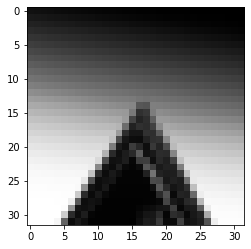

In [84]:
def prep_fn(img):
    img = img.astype(np.float32) / 255.0 # [0,1]
    img = (img - 0.5) * 2  # [0 -0.5 , 1 - 0.5] => [-0.5, 0.5] * 2 => [-1,1]
    return img

for path in filenames:
    img = img_to_array(load_img(
        path,
        grayscale=False,
        color_mode='rgb',
        target_size=image_size,
        interpolation='bilinear'
    ))
    # rescale [0,255] -> [-1,1]
    original_dataset.append(img)
    img = prep_fn(img)
    train_dataset.append(img)

plt.imshow(original_dataset[0].astype('uint8'))

train_dataset = np.array(train_dataset)
print(train_dataset.shape)

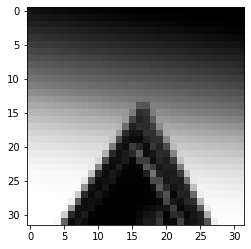

In [85]:
img_train = ((train_dataset/2 + 0.5)*255).astype('uint8')
plt.imshow(img_train[0])

In [86]:
#Random selected images
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0,dataset.shape[0], n_samples) #random image index
  # retreive selected images
  X = dataset[ix] # get image from random pick ix
  # generate y = 1 for 'real' class labels
  y = np.ones(shape=((n_samples,1)))# -> (y.shape = (n_samples,1))
  return X, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

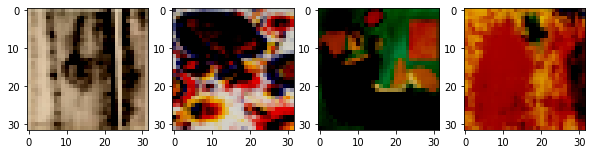

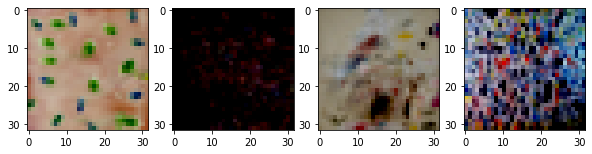

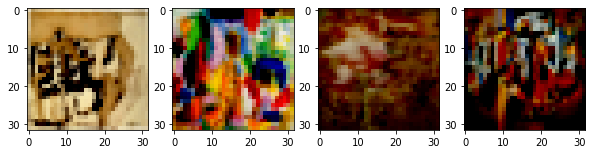

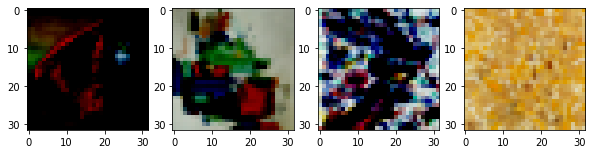

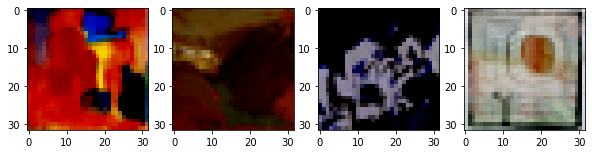

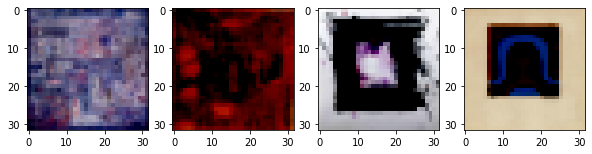

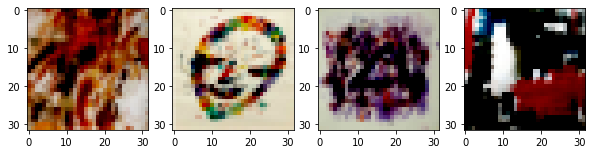

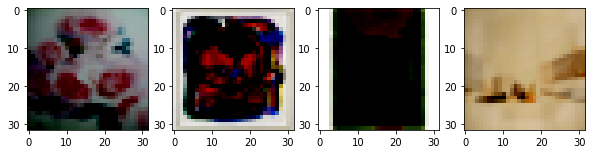

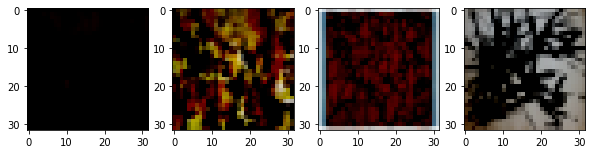

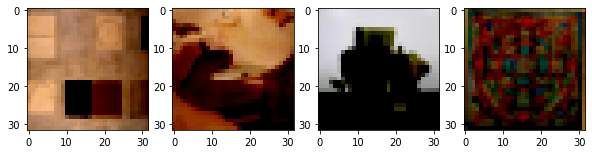

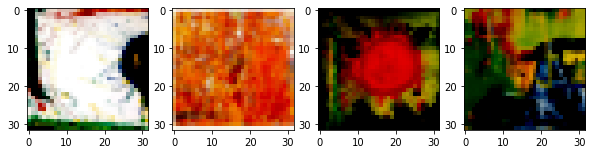

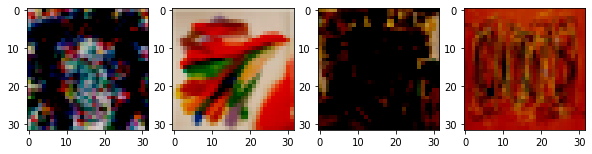

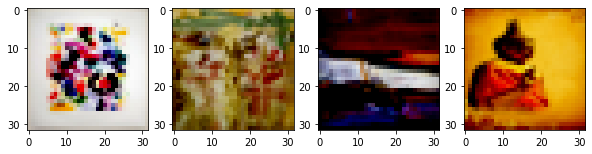

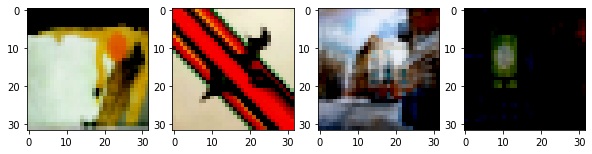

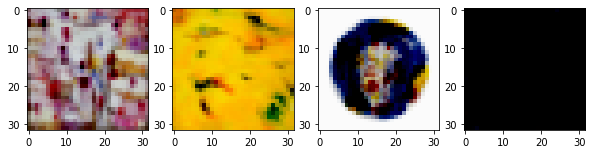

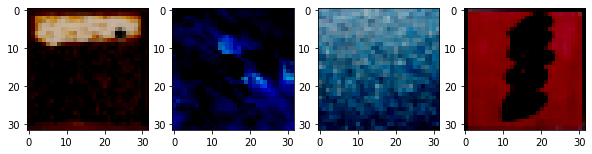

In [87]:
# Display Random Real Images
n_samples = 64
X_real, y_real = generate_real_samples(train_dataset, n_samples)

for i in range(len(X_real)):
  if i%4 == 0:
    fig = plt.figure(figsize=(10,10))
  plt.subplot(1,4,(i%4)+1)
  plt.imshow(X_real[i])

11.1.2 Prepare Fake Image innitial for training discriminator(D)

In [88]:
def generate_fake_samples(n_samples, target_size=(32,32,3)):
  h,w,c = target_size
  # generate 1D uniform random numbers in [0,1]
  X = np.random.uniform(0,1,(n_samples * h * w * c))
  # rescale X value from [0,1] to [-1,1]
  X = np.interp(X, (0,1), (-1,1))
  X = X.reshape((n_samples,h,w,c))
  y = np.zeros((n_samples,1))
  return X, y

In [89]:
# generate fake image samples
X_fake, y_fake = generate_fake_samples(n_samples, target_size=image_size)
# Display Random Real Images
# cv2.imshow(X_fake) # rescale to [0,255] -> dtype = uint8
X_fake.shape

(64, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

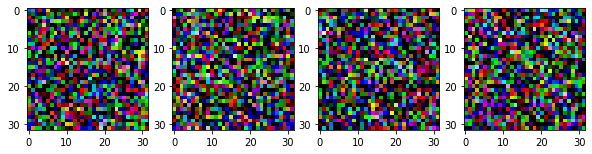

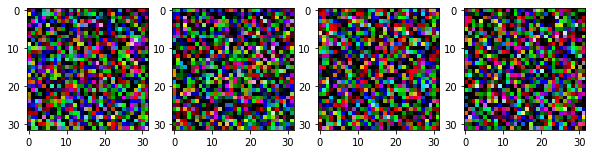

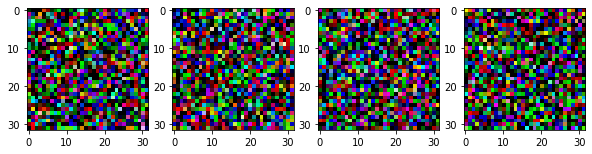

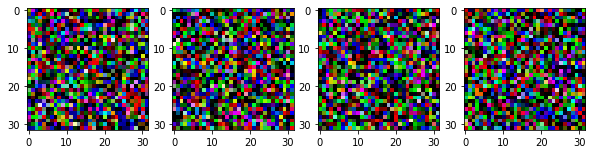

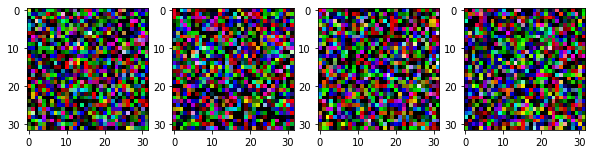

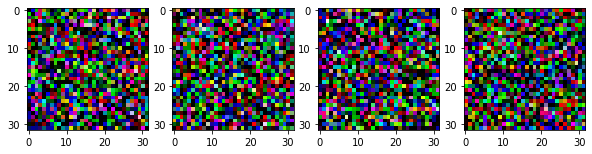

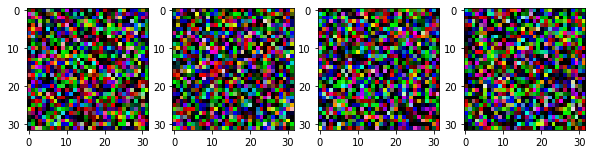

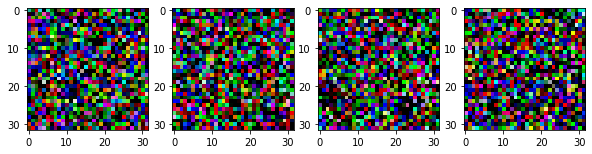

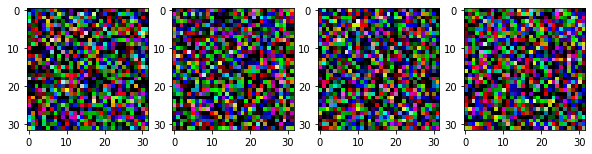

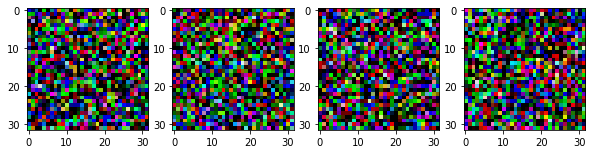

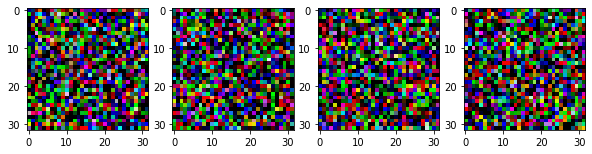

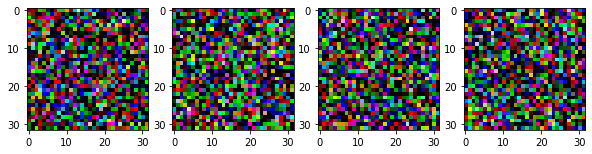

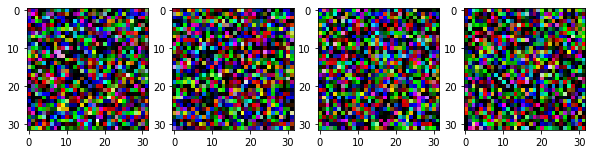

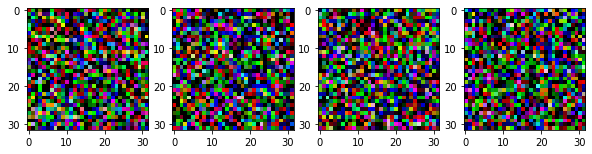

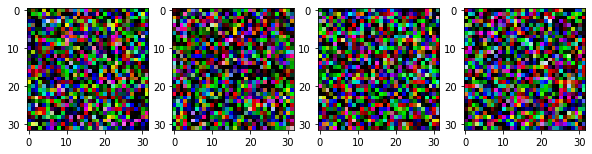

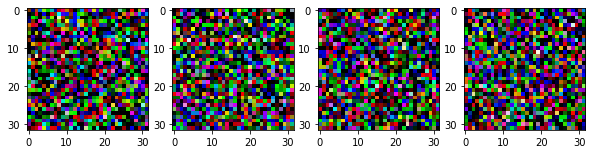

In [90]:
for i in range(len(X_fake)):
  if i%4 == 0:
    fig = plt.figure(figsize=(10,10))
  plt.subplot(1,4,(i%4)+1)
  plt.imshow(X_fake[i])

11.2 Prepare Discriminator Generator Model

11.2.1 Create Discriminator Model (D) and Training

In [91]:
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout

opt = Adam(lr=0.0002, beta_1=0.5)
CNN_L1,CNN_L2,CNN_L3,CNN_L4 = 128, 128, 64, 64

/Users/surawityosaeng/miniforge3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [92]:
# Discriminator Model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(CNN_L1, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  # downsample
  model.add(Conv2D(CNN_L2, (3,3), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # downsample
  model.add(Conv2D(CNN_L3, (3,3), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # downsample
  model.add(Conv2D(CNN_L4, (3,3), strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  # compile model
  model.compile(loss="binary_crossentropy", optimizer=opt ,metrics=['accuracy'])
  return model

In [93]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=60, n_batch=128, target_size=(32,32,3)):
  half_batch = int(n_batch / 2)
  # manually enumurate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator on real samples
    _, real_acc = model.train_on_batch(X_real, y_real)
    # generate 'fake' examples
    X_fake, y_fake = generate_fake_samples(half_batch, target_size=image_size)
    # update discriminator on fake samples
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    # summarize performance
    print(real_acc, fake_acc)

In [94]:
# define model
d_model = define_discriminator(image_size)

In [95]:
d_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          73792     
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 64)         

In [96]:
train_discriminator(d_model, train_dataset, target_size=image_size)

2022-04-25 20:14:47.699838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.796875 0.0
1.0 0.046875
1.0 0.03125
0.96875 0.171875
0.96875 0.421875
1.0 0.671875
0.96875 0.796875
0.96875 0.96875
0.984375 1.0
1.0 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
0.96875 1.0
0.96875 1.0
0.984375 1.0
1.0 1.0
0.984375 1.0
0.984375 1.0
0.984375 1.0
1.0 1.0
0.96875 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.984375 1.0
1.0 1.0
1.0 1.0
0.96875 1.0
1.0 1.0
1.0 1.0


11.2.2 Create Generator Model (G)

In [97]:
from keras.layers import Reshape

In [98]:
from keras.layers.convolutional import Conv2DTranspose
# define the standalone generator model

def define_generator(latent_dim, discr_out = (256,4,4)):
    model = Sequential()
    # foundation for 4x4 image
    c, w, h = discr_out
    n_nodes = c * w * h
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((w, h, c)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))


    # # upsample to 64x64
    # model.add(Conv2DTranspose(128, (w,h), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))


    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [99]:
# define the generator model
latent_dim = 100
mini_size = (4,4)
g_model = define_generator(latent_dim, discr_out = (256,mini_size[0],mini_size[1]))
g_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        524416    
 ranspose)                                                       
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

11.3 GAN Training and Prediction

11.2.3 Create GAN Model (G,D) and Training

In [100]:
# define the combined generator and discriminator model, for updatinf the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator|
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [101]:
def generate_latent_points(latent_dim, n_samples):
   # generate points in the latent space
   x_input = np.random.randn(latent_dim * n_samples)
   # reshape into a batch of inputs for the network
   x_input = x_input.reshape(n_samples, latent_dim)
   return x_input

Text(0.5, 1.0, 'X_real2')

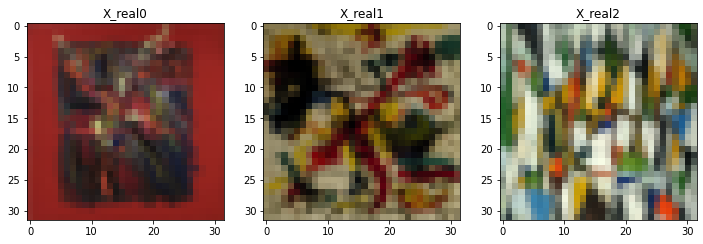

In [102]:
X_real, y_real = generate_real_samples(train_dataset, n_samples)
X_real = np.interp(X_real,(-1,1),(0,255))

plt.figure(figsize=(12,7))
plt.subplot(1,3,1)
plt.imshow(X_real[0].astype("uint8"))
plt.title('X_real0')
plt.subplot(1,3,2)
plt.imshow(X_real[1].astype("uint8"))
plt.title('X_real1')
plt.subplot(1,3,3)
plt.imshow(X_real[2].astype("uint8"))
plt.title('X_real2')


In [117]:

def generate_fake_samples(g_model,latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X, y

In [104]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(
                g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            # # create inverted labels for the fake samples y = 0 with shape (n_batch, )
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print(d_loss1, d_loss2, g_loss)  # summarize loss on this batch
            # evaluate the model performance, every Nepoch
            if (i+1) % 20 == 0:
                summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [106]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(acc_real , acc_fake)
  # save plot
  # save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

In [108]:
# create the gan
gan_model = define_gan(g_model, d_model)

# summarize gan model
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 262913    
                                                                 
Total params: 1,729,028
Trainable params: 1,466,115
Non-trainable params: 262,913
_________________________________________________________________


In [113]:
# train model
train(g_model, d_model, gan_model, train_dataset, latent_dim, n_epochs=400)

0.6941778063774109 0.6729645729064941 0.7885894775390625
0.6548142433166504 0.6562175154685974 0.8012162446975708
0.7063132524490356 0.683457612991333 0.7966384887695312
0.659972071647644 0.6989103555679321 0.7896124720573425
0.6421305537223816 0.7011637687683105 0.8197473287582397
0.7009857892990112 0.6491548418998718 0.7934070229530334
0.6474629640579224 0.654917299747467 0.8027443289756775
0.6527537107467651 0.635793149471283 0.7860634326934814
0.6875238418579102 0.6445580720901489 0.7829146981239319
0.690462589263916 0.6959636211395264 0.806215763092041
0.6410861015319824 0.6517053246498108 0.7949918508529663
0.6593132615089417 0.6725404262542725 0.8028514385223389
0.6617228388786316 0.6344656944274902 0.8248205184936523
0.6274922490119934 0.639096736907959 0.826396644115448
0.6830424666404724 0.6351369619369507 0.8196052312850952
0.6763314008712769 0.6517715454101562 0.7946593761444092
0.6460523009300232 0.6831609010696411 0.7739505171775818
0.6190076470375061 0.6834641695022583 0

In [110]:
X,_ = generate_fake_samples(g_model,latent_dim,n_samples)

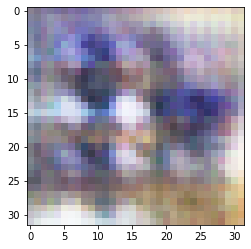

In [111]:
# print(X.shape)

plt.imshow(((X[3]/2 + 0.5)*255).astype("uint8"))
def printImage(X):
    index = 0
    f, ax = plt.subplots(4, 4, figsize=(12,12))  # figsize=(20, 20)
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(((X[index]/2 + 0.5)*255).astype("uint8"))  # 1-8
            index += 1
    plt.show()

./generator_model_020.h5


2022-04-26 11:10:51.443403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


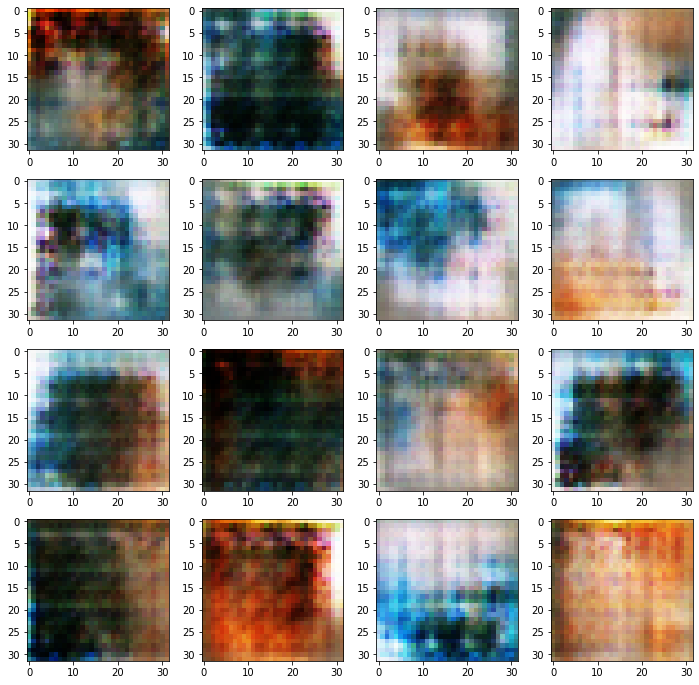

./generator_model_040.h5


2022-04-26 11:10:54.006084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


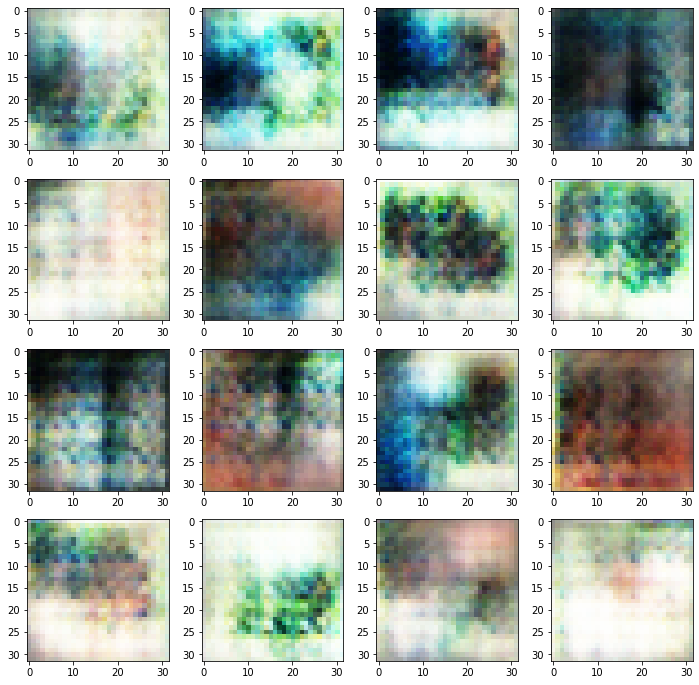

./generator_model_060.h5


2022-04-26 11:10:54.768202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


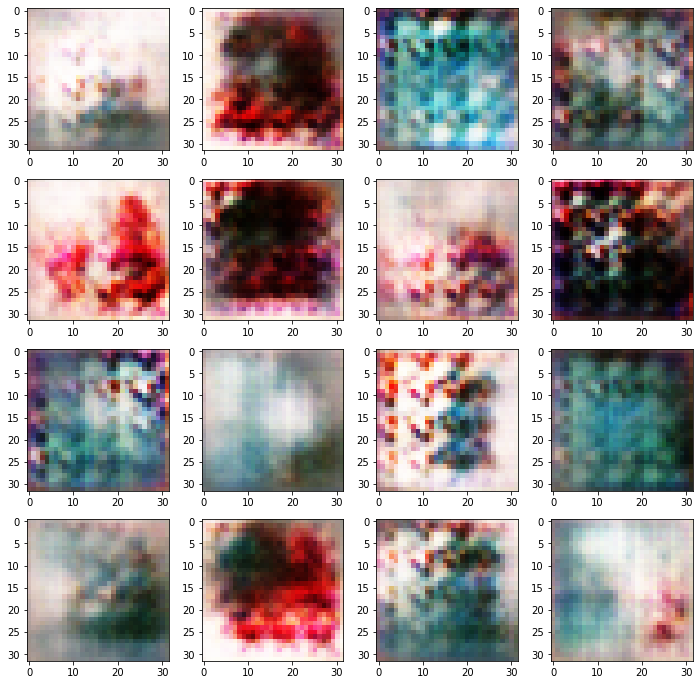

./generator_model_080.h5


2022-04-26 11:10:55.794435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


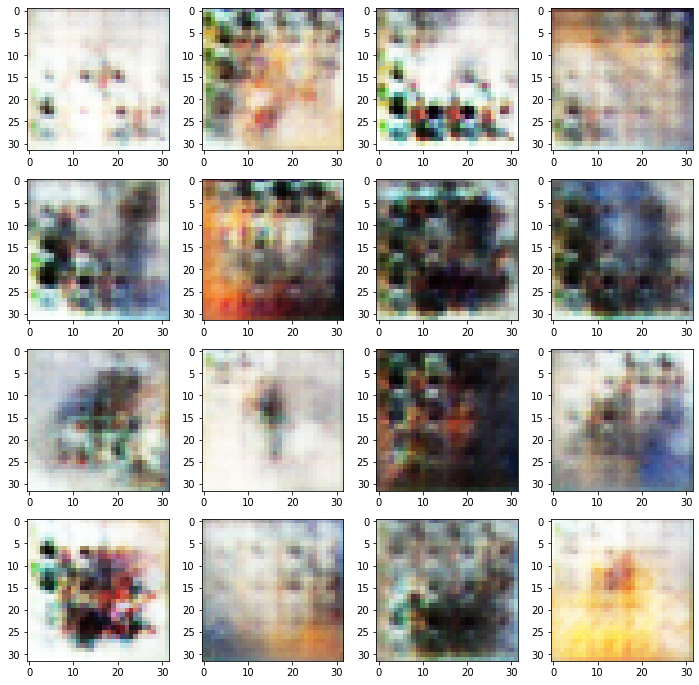

./generator_model_100.h5


2022-04-26 11:10:56.652615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


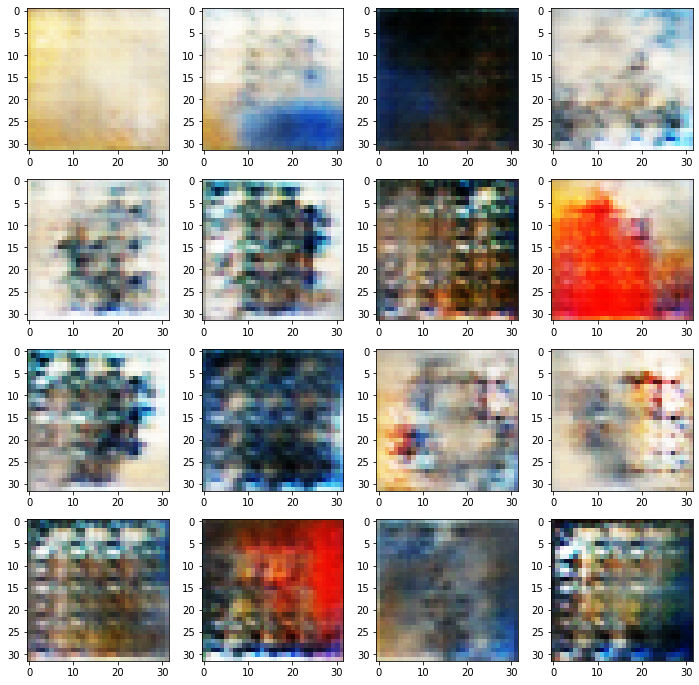

./generator_model_120.h5


2022-04-26 11:10:57.248373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


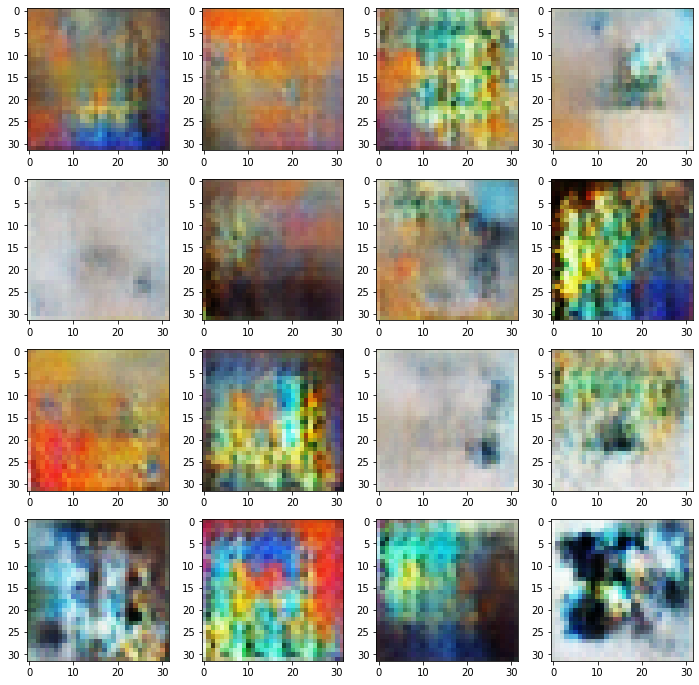

./generator_model_140.h5


2022-04-26 11:10:57.885052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


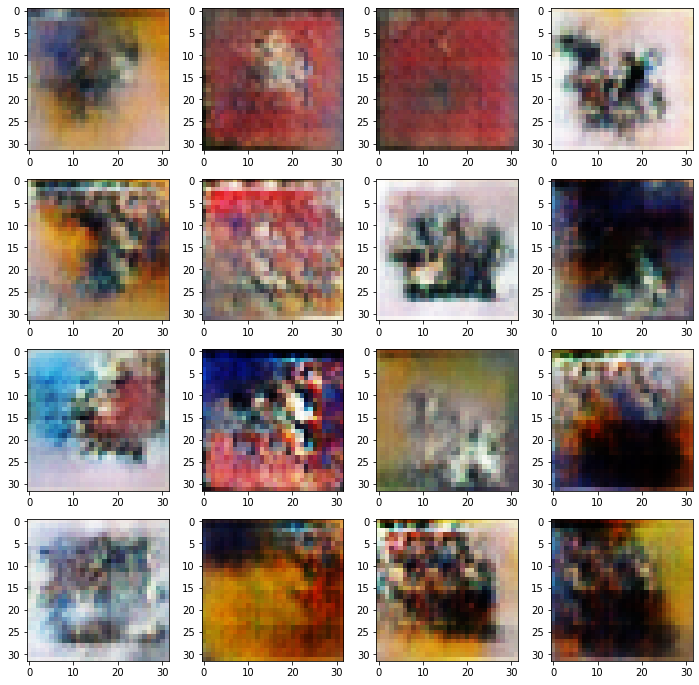

./generator_model_160.h5


2022-04-26 11:10:58.688810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


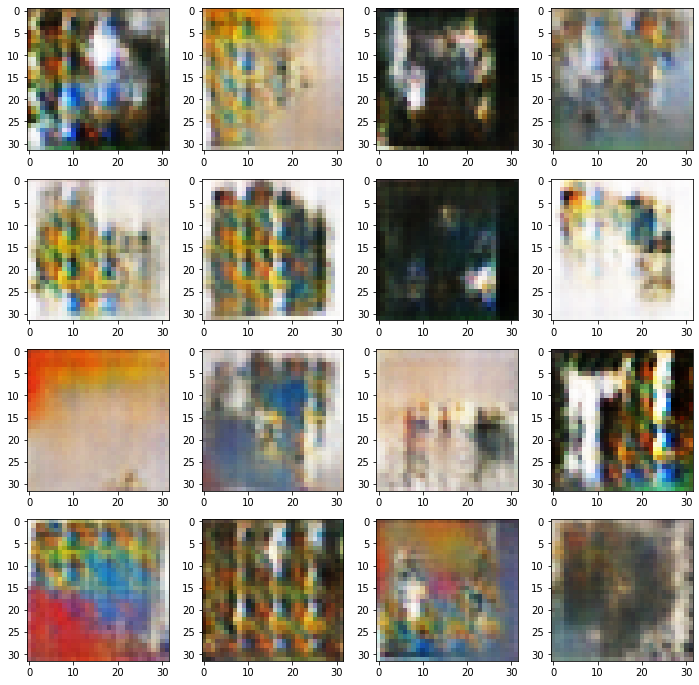

./generator_model_180.h5


2022-04-26 11:10:59.382312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


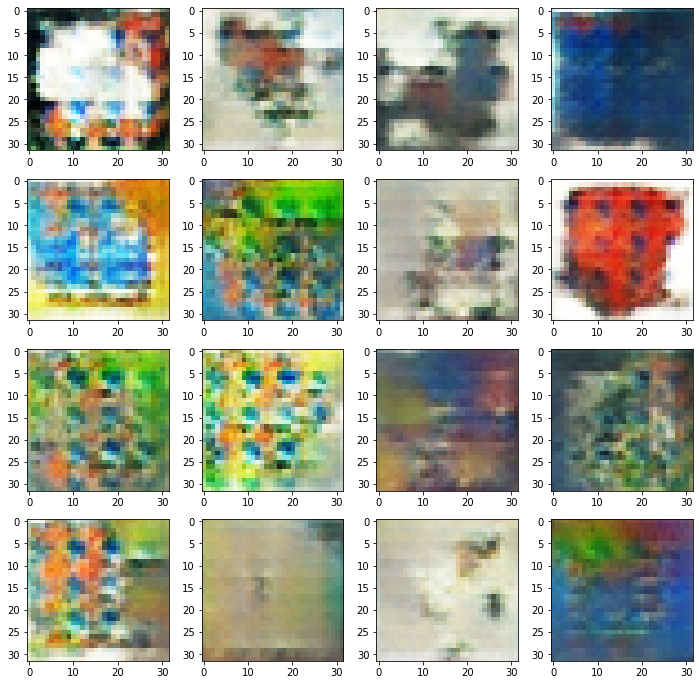

./generator_model_200.h5


2022-04-26 11:11:00.041116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


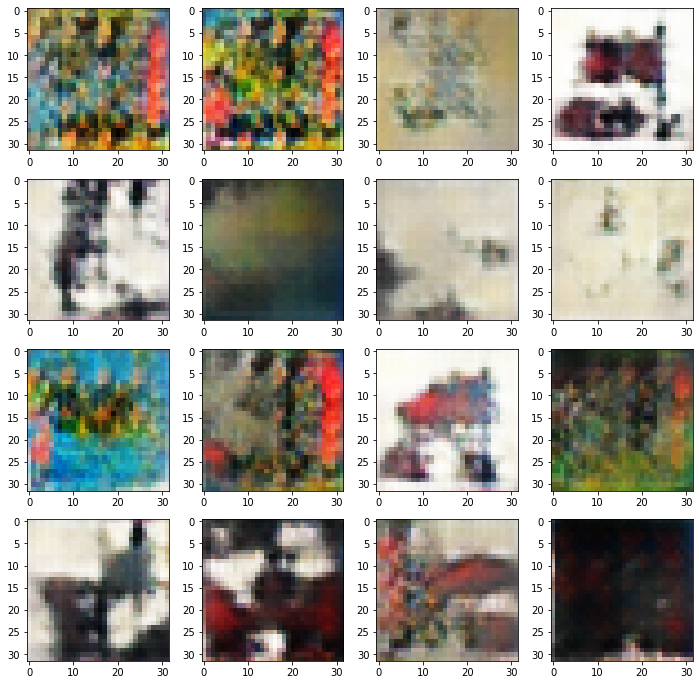

./generator_model_220.h5


2022-04-26 11:11:00.863608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


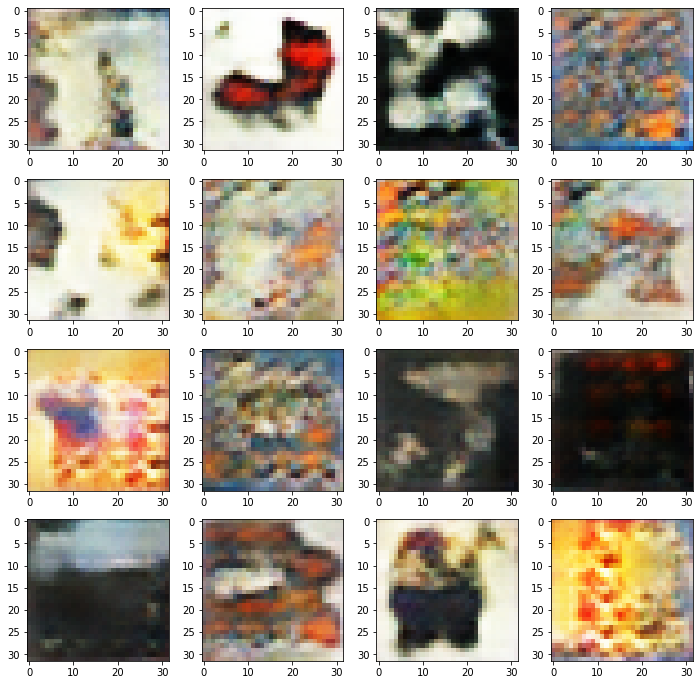

./generator_model_240.h5


2022-04-26 11:11:01.479046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


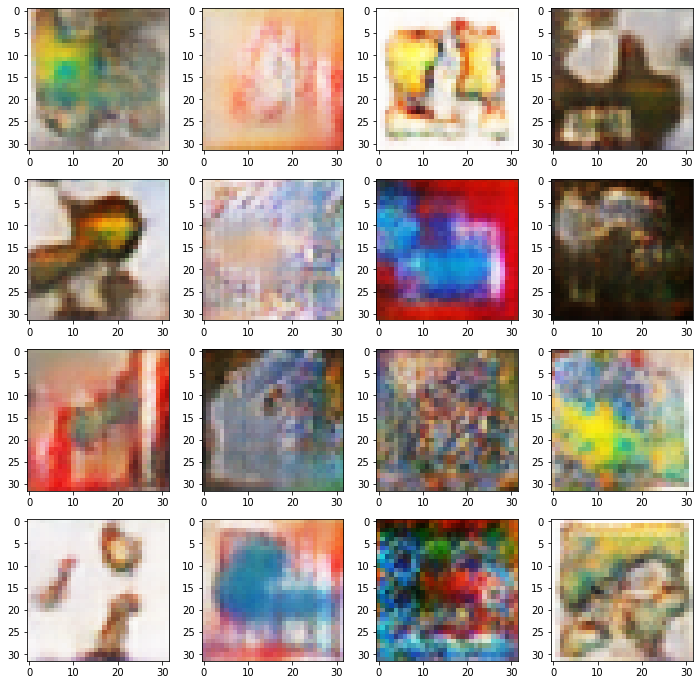

./generator_model_260.h5


2022-04-26 11:11:02.097345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


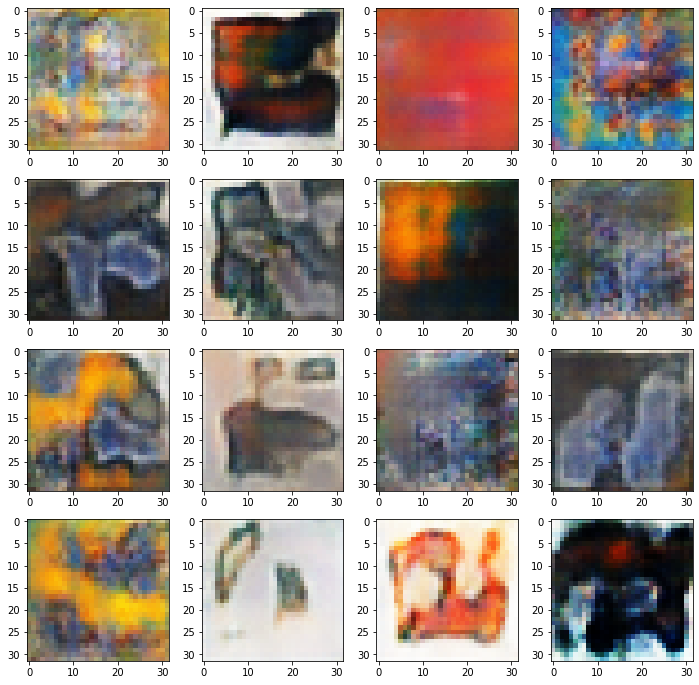

./generator_model_280.h5


2022-04-26 11:11:02.926368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


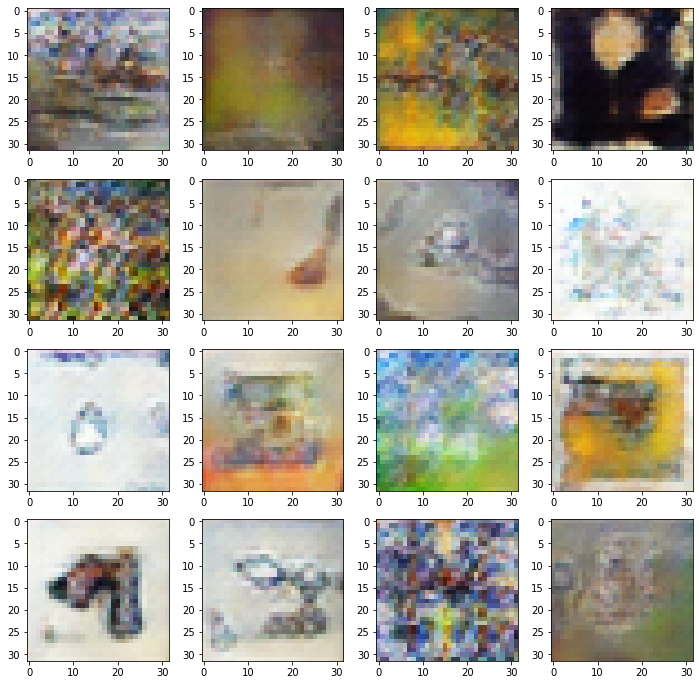

./generator_model_300.h5


2022-04-26 11:11:03.645640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


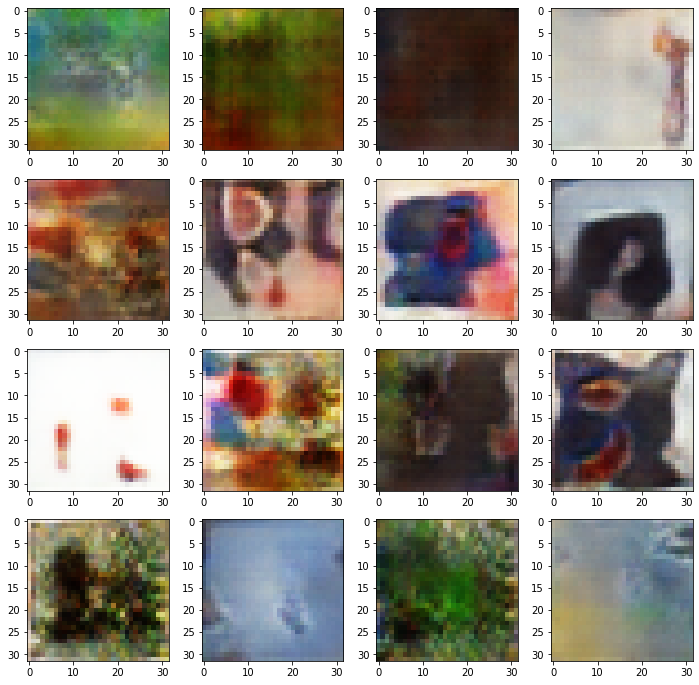

./generator_model_320.h5


2022-04-26 11:11:04.270116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


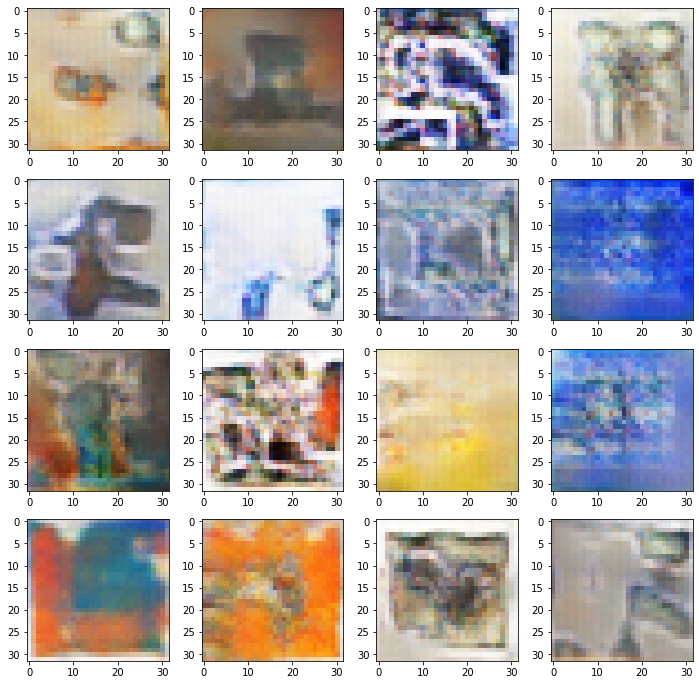

./generator_model_340.h5


2022-04-26 11:11:05.083193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


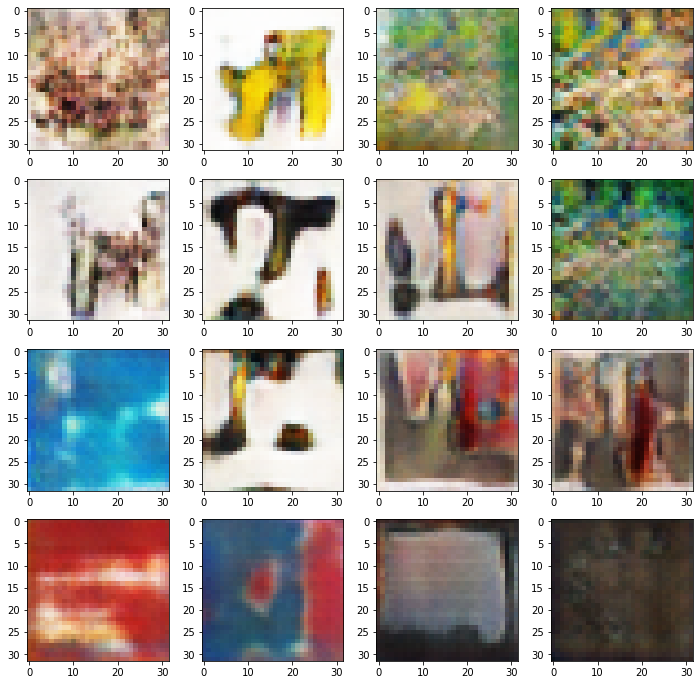

./generator_model_360.h5


2022-04-26 11:11:05.747857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


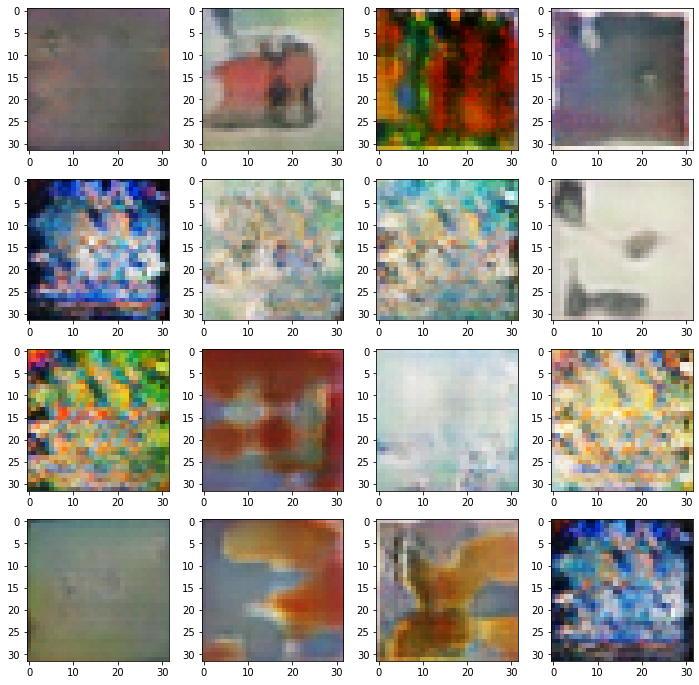

./generator_model_380.h5


2022-04-26 11:11:06.377273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


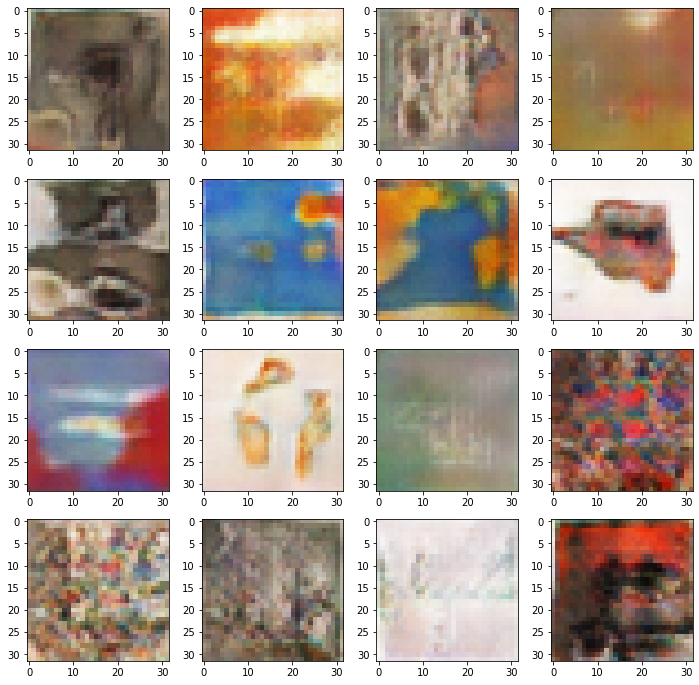

./generator_model_400.h5


2022-04-26 11:11:07.155823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


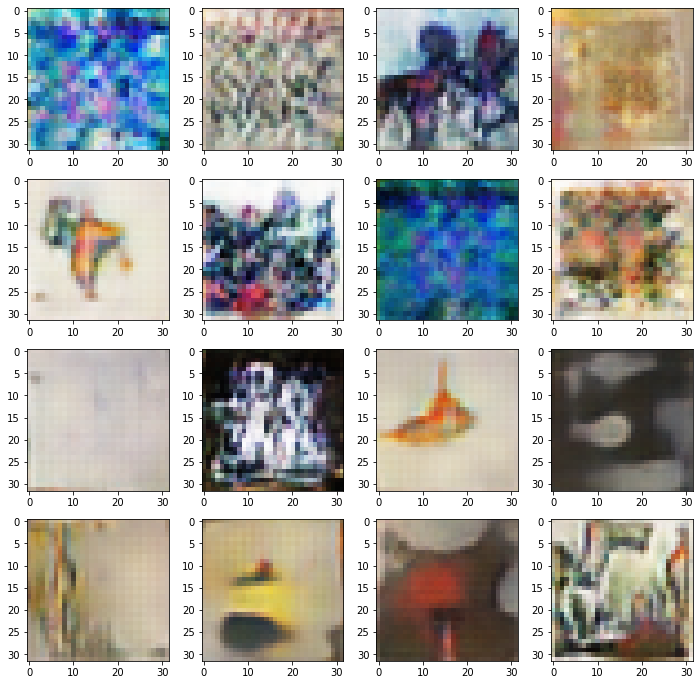

In [124]:
for i in range(20):
    path = './generator_model_%03d.h5' % ((i+1)*20)
    print(path)
    model = keras.models.load_model(path)
    X_during,_ = generate_fake_samples(model, latent_dim, n_samples)
    printImage(X_during)
